In [1]:
import os
import sys
import time
import json
import glob
import torch
import math
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from IPython import display
from typing import Optional, Tuple, List, Union, Callable
device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'

In [2]:
import torch.nn as nn
from torch.optim import Adam
import torch.nn.functional as f
import matplotlib.pyplot as plt
from PIL import Image
from mpl_toolkits.mplot3d import axes3d
from tqdm import tqdm
import numpy as np
import os
import sys

Mounted at /content/MyDrive/


100%|██████████| 400/400 [00:00<00:00, 1105.79it/s]


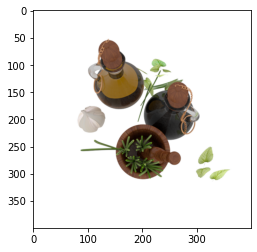

In [3]:
from google.colab import drive
drive.mount('/content/MyDrive/',force_remount = True)
bottles = '/content/MyDrive/MyDrive/CSE291/HW3/bottles/'
images = bottles + 'rgb/'
pose = bottles + 'pose/'
x = sorted(os.listdir(images))
newsize = (400,400)

train_images = np.array([])
for file in tqdm(sorted(os.listdir(images))):
  if file.endswith('.png'):
    image = (Image.open(images + file))
    image = image.resize(newsize)
    image = np.array(image)[:,:,:3]/255
    # print(image.shape)
    train_images = np.append(train_images, image)
train_images = train_images.reshape(-1,*newsize,3)

poses = np.zeros((200,4,4))
i = 0
for file in tqdm(sorted(os.listdir(pose))):
  if file.endswith('.txt') and ('train' in file or 'val' in file):
    poses[i] = np.loadtxt(pose + file)
    i+=1

K_cam = np.loadtxt(bottles + 'intrinsics.txt')
K_cam[:2, :3] = K_cam[:2, :3] / (800 / newsize[0])

plt.imshow(train_images[2])

focal = K_cam[0][0]

In [4]:
focal

437.5

In [5]:
train_images_tensor = torch.from_numpy(train_images[:180])
train_poses_tensor = torch.from_numpy(poses[:180])
train_images_tensor = train_images_tensor.type(torch.float32)
train_poses_tensor =  train_poses_tensor.type(torch.float32)
train_images_tensor = train_images_tensor
train_poses_tensor = train_poses_tensor
testimg, testpose = torch.from_numpy(train_images[190]), torch.from_numpy(poses[190])

For NeRF, we need to get the ray origin and ray directions from the images first, each pixel in an image can be described as a point along a ray starting from origin which is the camera optical frame origin, as r(t) = o + td where t is a parameter and d is the ray direction. For a given image, o will be same for all points but the direction will be different

In [6]:
def rays(cam2world, height = 800, width = 800, f = focal):
  '''
  get the camera origin and ray directions from the given image 
  '''
  u,v = torch.meshgrid(torch.arange(width, dtype = torch.float32).to(cam2world), 
                       torch.arange(height, dtype = torch.float32).to(cam2world), indexing = 'ij')
  u = u.transpose(-1,-2)
  v = v.transpose(-1,-2)
  dirs = torch.stack([(u - width / 2) / f, -(height /2 - v) / f, torch.ones_like(u)], dim = -1)

  #right now the direction vectors are in the camera optical frame, need to convert these to world frame using the camera extrinsic matrix for this image

  dirs = torch.sum(dirs[..., None, :] * cam2world[:3, :3], dim = -1)
  origin = cam2world[:3,-1].expand(dirs.shape)
  return origin, dirs

Now we have the ray origin and direction for each image, ideally what we do is sample points from these rays, query these points into our NeRF MLP to get the rgb pixel and color density at this location. We then use classical volume rendering concepts to compose these rgb values and color density into image pixel values. But this strategy of getting rays and sampling points is highly inefficient since there maybe points that are occluded by others in the image and hence we should not sample these points too often. 

Hence the NeRF paper proposes a stratified resampling method such that points that are occluded are not sampled enough. Below is the stratified sampling method for the rays

In [8]:
def stratified_sampling(origin, dirs, near, far, num_samples, perturb = True, inverse_depth = False):
  '''
  given the ray origin and ray directions, sample points along the rays
  use a stratified sampling approach instead of a uniform sampling approach 
  '''
  t = torch.linspace(0,1,num_samples, device = origin.device)
  if not inverse_depth:
    z = near * (1 - t) + far * t
  else:
    z = 1/(1/near * (1 -t ) + 1/far*(t))
  
  if perturb:
    middle = (z[1:] + z[:-1])/2
    upper = torch.concat([middle, z[-1:]], dim = -1)
    lower = torch.concat([z[:1], middle], dim = -1)
    rand_t = torch.rand([num_samples]).to(origin.device)
    z = lower + (upper - lower) * rand_t
  z = z.expand(list(origin.shape[:-1]) + [num_samples])
  samples = origin[...,None,:] + dirs[...,None,:] * z[...,:,None]
  return samples, z


In [9]:
near , far = 0, 5

In [12]:
class Encoder(nn.Module):
  '''
  positional encoding for the NERF
  convert the input to a higher dimensional space using alternating sin and cosine functions
  '''
  def __init__(self, n_freq = 10):
    super().__init__()
    self.embed_funcs = [lambda x : x]
    frequencies = 2.**torch.linspace(0., n_freq - 1, n_freq)
    for f in frequencies:
      self.embed_funcs.append(lambda x : torch.sin(f * x))
      self.embed_funcs.append(lambda x : torch.cos(f * x))
    
    self.output_dim = 3 * ( 1 + 2 * n_freq)

  def forward(self, x):
    return torch.concat([fn(x) for fn in self.embed_funcs], dim = -1)

In [13]:
class NeRF(nn.Module):
  '''
  Neural Radiance Field MLP network
  8 fully connected layers on the input
  skip connection at 5th layer (concat original input to output of 4th layer)
  '''
  def __init__(self, input_dim = 3, feature_dim = 256, num_layers = 8, skip_layer = [4], view_direction : Optional[int] = None):
    super().__init__()
    self.input_dim = input_dim
    self.feature_dim = feature_dim
    self.skip = skip_layer
    self.activation = f.softplus
    self.view_direction = view_direction

    self.MLP = nn.ModuleList([nn.Linear(self.input_dim, self.feature_dim)] + 
                             [nn.Linear(self.feature_dim + self.input_dim,self.feature_dim) if i in self.skip \
                             else nn.Linear(self.feature_dim, self.feature_dim) for i in range(num_layers - 1)])
    
    self.sigma = nn.Linear(self.feature_dim, 1) #color density output
    self.rgb = nn.Linear(self.feature_dim, self.feature_dim)
    self.branch = nn.Linear(self.feature_dim + self.view_direction, self.feature_dim // 2)
    self.output = nn.Linear(self.feature_dim // 2, 3) #rgb output

  def forward(self, x, viewdirs):
    '''
    forward function for NeRF to get the rgb and color density value for a given point and viewing direction 
    '''
    # print(f"shape of x : {x.shape}")
    # print(f"shape of dirs : {viewdirs.shape}")
    x_inp = x
    for i, layer in enumerate(self.MLP):
      x = self.activation(layer(x))
      if i in self.skip:
        x= torch.concat([x, x_inp], dim = -1)
    # print(f"Running inside NeRF forward")
    sigma = self.sigma(x)
    out_temp = self.rgb(x)
    out_temp = torch.concat([out_temp, viewdirs], dim = -1)
    output = self.activation(self.branch(out_temp))
    output = self.output(output)
    output = torch.concat([output, sigma], dim = -1)
    return output

In [14]:
def cumulative_product(input):
  '''
  '''
  prod = torch.cumprod(input, -1)
  prod = torch.roll(prod, 1,-1)
  prod[...,0] = 1
  return prod

def nerf2rgb(nerf_out, z, dirs):
  '''
  do the volume rendering from the nerf output to get the image rendering
  can also get depth map
  '''
  delta = z[...,1:] - z[...,:-1]
  delta = torch.cat([delta, 1e10* torch.ones_like(delta[...,:1])], dim = -1)
  delta = delta * torch.norm(dirs[...,None,:], dim = -1)
  # print(f"delta device : {delta.device}")
  noise = torch.randn(nerf_out[...,3].shape, device = nerf_out.device) * 1.0

  #Add slight noise to add to the delta which acts as small regulariser
  # print(f"noise device : {noise.device}")
  # print(f"nerf detached device : {nerf_out.detach().cpu().device}")
  alpha = 1.0 - torch.exp(-f.relu(nerf_out[...,3] + noise) * delta)
  w = alpha * torch.cumprod(torch.cat([torch.ones((alpha.shape[0], 1)).to(nerf_out.device), 1.-alpha + 1e-10], -1), -1)[:, :-1]
  
  #rgb map
  rgb = torch.sigmoid(nerf_out[...,:3])
  rgb_map = torch.sum(w[...,None] * rgb, dim = -2)

  #depth map
  #distance / depth is the computed distance along the rays itself
  depth_map = torch.sum(w * z, dim = -1)
  acc_map = torch.sum(w, dim = -1)
  rgb_map = rgb_map + (1 - acc_map[...,None])

  return rgb_map, depth_map, w


## Hierarchial Volume Sampling
Strategy to sample more points that are not occluded and sample less points which are occluded. Use the weights computed by the coarse network to compute a pdf along rays, then apply inverse transform sampling to this PDF to get second set of more imapctful samples

In [15]:
def pdf(middle, w, num_samples, perturb = False):
  '''
  create a sample pdf  along the rays based on the weights obtained above. 
  Larger value means the ray is more likely to be absorbed at this point and hence points beyond this are more likely to be occluded
  Hence we should not sample points beyond this point
  '''
  pdf = (w + 1e-5) / torch.sum(w + 1e-5, -1, keepdim=True)
  cdf = torch.cumsum(pdf, dim = -1)
  cdf = torch.concat([torch.zeros_like(cdf[...,:1]), cdf], dim = -1)

  #Sample points according to cdf
  if not perturb:
    u = torch.linspace(0,1,num_samples, device = device)
    u = u.expand(list(cdf.shape[:-1]) + [num_samples])
  else:
    u = torch.rand(list(cdf.shape[:-1]) + [num_samples], device = device)
  
  u = u.contiguous()
  index = torch.searchsorted(cdf, u, right = True)

  below = torch.clamp(index -1 , min = 0)
  upper = torch.clamp(index, max = cdf.shape[-1] - 1)
  index_correct = torch.stack([below, upper], dim = -1)

  #Sample from cdf and corresponding proper bin centers
  matched_shape = list(index_correct.shape[:-1]) + [cdf.shape[-1]]
  cdf_correct = torch.gather(cdf.unsqueeze(-2).expand(matched_shape), dim = -1, index = index_correct)
  middle_bins = torch.gather(middle.unsqueeze(-2).expand(matched_shape), dim = -1, index = index_correct)
  dr = cdf_correct[...,1] - cdf_correct[...,0]
  dr = torch.where(dr < 1e-5, torch.ones_like(dr), dr)
  t = (u - cdf_correct[...,0]) / dr
  samples = middle_bins[...,0] + t * (middle_bins[...,1] - middle_bins[...,0])

  return samples


In [16]:
def hierarchial_sampling(origin, dirs, z, w, num_samples = 64, perturb = False):
  '''
  '''
  middle = (z[...,:-1] + z[...,1:])/2
  sampled_z = pdf(middle, w[...,1:-1],num_samples,perturb)
  sampled_z = sampled_z.detach()
  samples_combined, _= torch.sort(torch.cat([z, sampled_z], dim = -1), dim = -1)
  points = origin[...,None,:] + dirs[...,None,:] * samples_combined[..., :, None]
  # print(f"sampled_z device : {sampled_z.device}")
  # print(f"samples combined device : {samples_combined.device}")
  # print(f"points device : {points.device}")
  return points, samples_combined, sampled_z

## Prepare for forward pass
NeRF has huge memory requirements for the MLP. Hence a basic idea in NeRF implementations was to distribute the data into chunks for incremental processing. 

In [17]:
def chunkify(inputs, chunksize = 2**15):
  '''
  '''
  return [inputs[i : i + chunksize] for i in range(0, inputs.shape[0], chunksize)]

def get_point_chunks(points, encoder, chunksize = 2**15):
  '''
  chunkify the (x,y,z) portion of input
  '''
  points = points.reshape((-1,3))
  points = encoder(points)
  points = chunkify(points)
  return points

def get_dirs_chunks(points, dirs, encoder, chunksize = 2**15):
  '''
  chunkify the viewing direction portion of input
  '''
  d = dirs / torch.norm(dirs, dim = -1, keepdim=True)
  d = d[:,None,...].expand(points.shape).reshape((-1,3))
  d = encoder(d)
  dirs = chunkify(d)
  return dirs

In [18]:
def nerf_train(origin, dirs, near, far, encoder_pos, encoder_dirs, coarse_module, fine_module, 
               num_hierarchial_samples, kwargs_stratified, kwards_hierarchial, chunksize = 2**10):
  '''
  put everything together, get the origin and dirs as input
  output the coarse model nerf and fine model nerf output
  do volume rendering to render the scene
  '''
  points, z_points = stratified_sampling(origin, dirs, near, far, **kwargs_stratified)
  # print(f"points : {points.shape} || z : {z_points.shape}")
  pos_batches = get_point_chunks(points, encoder_pos, chunksize= chunksize)
  dirs_batches = get_dirs_chunks(points, dirs, encoder_dirs, chunksize = chunksize)
  # print(pos_batches.shape)
  # print(dirs_batches.shape)
  outputs = []
  for point_batch, dir_batch in zip(pos_batches, dirs_batches):
    outputs.append(coarse_module(point_batch.float().to(device), dir_batch.float().to(device)))
  # print(outputs)
  nerf_output = torch.cat(outputs, dim = 0)
  nerf_output = nerf_output.reshape(list(points.shape[:2]) + [nerf_output.shape[-1]])
  nerf_data = {'z_vals_strat' : z_points}
  #volume rendering on this coarse model output to synthesise rgb and other map images if required
  rgb_map, depth_map, weights = nerf2rgb(nerf_output, z_points, dirs)

  #now we do the fine model pass based on the coarse model output using heirarchial sampling
  if num_hierarchial_samples > 0:
    rgb_map_coarse, depth_map_coarse = rgb_map, depth_map

    points_fine, z_vals_combined, z_vals_fine = hierarchial_sampling(origin, dirs, z_points, weights, num_hierarchial_samples, **kwargs_hierarchial)

    pos_batches = get_point_chunks(points_fine, encoder_pos, chunksize= chunksize)
    dirs_batches = get_dirs_chunks(points_fine, dirs, encoder_dirs, chunksize = chunksize)
    outputs = []
    for point_batch, dir_batch in zip(pos_batches, dirs_batches):
      outputs.append(fine_module(point_batch.float().to(device), dir_batch.float().to(device)))
    nerf_output = torch.cat(outputs, dim = 0)
    nerf_output = nerf_output.reshape(list(points_fine.shape[:2]) + [nerf_output.shape[-1]])

    rgb_map, depth_map, weights = nerf2rgb(nerf_output, z_vals_combined, dirs)
    
    nerf_data['z_vals_hierarchial'] = z_vals_fine
    nerf_data['rgb_map_coarse'] = rgb_map_coarse
    nerf_data['depth_map_coarse'] = depth_map_coarse

  
  nerf_data['rgb_map'] = rgb_map
  nerf_data['depth_map'] = depth_map
  nerf_data['weights'] = weights
  return nerf_data



## Setting important hyperparameters

In [102]:
pos_num_freq = 10
dirs_num_freq = 4

#number of points to sample from each ray 
num_samples = 64
perturb = True
inverse_depth = False

#Define the coarse and fine models for nerf
coarse_filter_dim = 256
num_layers_coarse = 4
skip_coarse = [1]
use_fine_model = False
fine_filter_dim = 64
skip_fine=[]
num_layers_fine = 2

#Hierarchial sampling parameters
num_hierarchial_samples = 0
perturb_hierarchial = False

#Optimizer
lr = 5e-4

#training
iterations = 200_000
batch_size = 2**12
one_image_per_step = False
chunksize = 2**12
display_rate = 2000

kwargs_stratified = {
    'num_samples' : num_samples, 
    'perturb' : perturb, 
    'inverse_depth' : inverse_depth
}

kwargs_hierarchial = {
    'perturb' : perturb
}

# Early Stopping
warmup_iters = 100          # Number of iterations during warmup phase
warmup_min_fitness = 10.0   # Min val PSNR to continue training at warmup_iters
n_restarts = 10             # Number of times to restart if training stalls

In [103]:

def plot_samples(
  z_vals,z_hierarch,ax):
  """
  Plot stratified and (optional) hierarchical samples.
  """
  y_vals = 1 + np.zeros_like(z_vals)

  if ax is None:
    ax = plt.subplot()
  ax.plot(z_vals, y_vals, 'b-o')
  if z_hierarch is not None:
    y_hierarch = np.zeros_like(z_hierarch)
    ax.plot(z_hierarch, y_hierarch, 'r-o')
  ax.set_ylim([-1, 2])
  ax.set_title('Stratified  Samples (blue) and Hierarchical Samples (red)')
  ax.axes.yaxis.set_visible(False)
  ax.grid(True)
  return ax



class EarlyStopping:
  '''
  Early stopping based on fitness criteria
  '''
  def __init__(self, patience = 30, margin = 1e-4):
    self.best_fitness = 0
    self.best_iter = 0
    self.margin = margin 
    self.patience = patience or float('inf')

  def __call__(self, iter, fitness):
    '''
    checking if criteria for stopping is met
    '''
    if (fitness - self.best_fitness) > self.margin: 
      self.best_iter = iter
      self.best_fitness = fitness

    change = iter - self.best_iter
    stop = change >= self.patience
    return stop


In [104]:
def create_models():
  '''
  Prepare all coarse, fine models, pos encoder, direction encoders
  '''
  #Positional and directional encoders
  pos_encoder = Encoder(pos_num_freq)
  pos_encode = lambda x : pos_encoder(x)

  dir_encoder = Encoder(dirs_num_freq)
  dir_encode = lambda x : dir_encoder(x)
  view_direction = dir_encoder.output_dim
  #Coarse and fine model for nerf
  coarse_model = NeRF(pos_encoder.output_dim, coarse_filter_dim, num_layers_coarse, skip_coarse, view_direction)
  coarse_model.to(device)
  model_params = list(coarse_model.parameters())

  if use_fine_model:
    fine_model = NeRF(pos_encoder.output_dim, fine_filter_dim, num_layers_fine, skip_fine, view_direction)
    fine_model.to(device)
    model_params = model_params + list(fine_model.parameters())
  else:
    fine_model = None
  
  optimizer = torch.optim.Adam(model_params, lr = lr)
  warmup_stopper = EarlyStopping(patience = 50)

  return coarse_model, fine_model, pos_encode, dir_encode, optimizer, warmup_stopper


In [105]:
n_training = 130

In [106]:
def train():
  '''
  train the model
  '''
  if not one_image_per_step:
    height, width = train_images_tensor.shape[1:3]
    all_rays = torch.stack([torch.stack(rays(p.to('cpu'),height, width, focal), 0)
                        for p in train_poses_tensor[:n_training]], 0)
    rays_rgb = torch.cat([all_rays, train_images_tensor[:n_training, None]], 1)
    rays_rgb = torch.permute(rays_rgb, [0, 2, 3, 1, 4])
    rays_rgb = rays_rgb.reshape([-1, 3, 3])
    rays_rgb = rays_rgb.type(torch.float32)
    rays_rgb = rays_rgb[torch.randperm(rays_rgb.shape[0])]
    i_batch = 0
  train_psnrs, val_psnrs, iternums = [], [], []
  for i in tqdm(range(iterations)):
    model.train()
    new_lr = lr * (0.1 ** (i / 75000))
    for param_groups in optimizer.param_groups:
      param_groups['lr'] = new_lr
    if one_image_per_step:
      image_index = np.random.randint(train_images_tensor.shape[0])
      # image_index = np.random.randint(10)
      image = train_images_tensor[image_index].to(device)
      height, width = image.shape[:2]
      pose = train_poses_tensor[image_index].to(device)
      origin, dirs = rays(pose, height, width, focal)
      # print(f"origin device : {origin.device}")
      origin = origin.reshape([-1,3])
      dirs = dirs.reshape([-1,3])
    else:
      batch = rays_rgb[i_batch:i_batch + batch_size]
      batch = torch.transpose(batch, 0, 1)
      origin, dirs, image = batch
      origin = origin.to(device)
      dirs = dirs.to(device)
      height, width = image.shape[:2]
      i_batch += batch_size
      # Shuffle after one epoch
      if i_batch >= rays_rgb.shape[0]:
          rays_rgb = rays_rgb[torch.randperm(rays_rgb.shape[0])]
          i_batch = 0
    image = image.reshape([-1,3])

    nerf_outputs = nerf_train(origin, dirs, near, far, pos_encode, dir_encode, model, fine_model, 
                              num_hierarchial_samples, kwargs_stratified, kwargs_hierarchial, chunksize = chunksize)
    
    for k,v in nerf_outputs.items():
      if torch.isnan(v).any():
        print(f"Numerical alert : {k} CONTAINS NAN")
      if torch.isinf(v).any():
        print(f"Numerical alert : {k} CONTAINS inf")
      
    #Backpropagation
    rgb_map = nerf_outputs['rgb_map']
    # print(f"prediceted image device : {rgb_map.device}")
    loss = f.mse_loss(rgb_map, image.to(device))
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    psnr = -10 * torch.log10(loss)
    train_psnrs.append(psnr.item())
    #Evaluate at a given frequency 
    
    # scheduler.step()
    
    if i % display_rate == 0:
      model.eval()
      with torch.no_grad():
        height, width = testimg.shape[:2]
        test_origin, test_dirs = rays(testpose.to(device), height, width, focal)
        test_origin = test_origin.reshape([-1,3])
        test_dirs = test_dirs.reshape([-1, 3])
        nerf_output = nerf_train(test_origin, test_dirs, near, far, pos_encode, dir_encode, model, fine_model, 
                                  num_hierarchial_samples, kwargs_stratified, kwargs_hierarchial, chunksize)
        rgb_val = nerf_output['rgb_map']
        loss = f.mse_loss(rgb_val, testimg.reshape([-1,3]).to(device))
        val_psnr =  -10 *torch.log10(loss)
        val_psnrs.append(val_psnr.item())
        iternums.append(i)
      if i % (5 * display_rate) == 0:
        torch.save({
            'epochs': i,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'training_psnr' : train_psnrs,
            'validation_psnr' : val_psnrs
            }, save_model_dir + f'checkpoint{i}_lrDecay_PosEncoding{pos_num_freq}_ViewDirEncoding{dirs_num_freq}_LayerDim_{coarse_filter_dim}_nerf.tar')
      print(f"validation PSNR : {val_psnr}")

      # Plot example outputs
      fig, ax = plt.subplots(1, 3, figsize=(15,4), gridspec_kw={'width_ratios': [1, 1, 1]})
      ax[0].imshow(rgb_val.reshape([height, width, 3]).detach().cpu().numpy())
      ax[0].set_title(f'Iteration: {i}')
      ax[1].imshow(testimg.detach().cpu().numpy())
      ax[1].set_title(f'Target')
      ax[2].plot(range(0, i + 1), train_psnrs, 'r')
      ax[2].plot(iternums, val_psnrs, 'b')
      ax[2].set_title('PSNR (train=red, val=blue')
      if i % 2_000 == 0:
        plt.savefig(save_image_dir + f'val{i}_PosEncoding{pos_num_freq}_ViewDirEncoding{dirs_num_freq}_LayerDim_{coarse_filter_dim}.png',
                    bbox_inches = 'tight')
      plt.show()

      if i == warmup_iters - 1:
        if val_psnr < warmup_min_fitness:
          print(f'Val PSNR {val_psnr} below warmup_min_fitness {warmup_min_fitness}. Stopping...')
          return False, train_psnrs, val_psnrs
        elif i < warmup_iters:
          if warmup_stopper is not None and warmup_stopper(i, psnr):
            print(f'Train PSNR flatlined at {psnr} for {warmup_stopper.patience} iters. Stopping...')
            return False, train_psnrs, val_psnrs

  return True, train_psnrs, val_psnrs



In [108]:
for _ in range(n_restarts):
  model, fine_model, pos_encode, dir_encode, optimizer, warmup_stopper = create_models()
  near, far = 0, 5
  save_image_dir = '/content/MyDrive/MyDrive/CSE291/HW3/images/'
  save_model_dir = '/content/MyDrive/MyDrive/CSE291/HW3/models/'
  # success, train_psnrs, val_psnrs = train()
  # if success and val_psnrs[-1] >= warmup_min_fitness:
  #   print('Training succesfull')
  #   break
  # print("Done")

## Generating test images, validation images, PSNR of validation images

In [109]:
training_dict = torch.load(save_model_dir + 'checkpoint190000_PosEncoding10_ViewDirEncoding4_LayerDim_256_nerf.tar')

In [110]:
model.load_state_dict(training_dict['model_state_dict'])

<All keys matched successfully>

In [111]:
y = sorted(list(os.listdir(pose)))
print(y)

['0_train_0000.txt', '0_train_0001.txt', '0_train_0002.txt', '0_train_0003.txt', '0_train_0004.txt', '0_train_0005.txt', '0_train_0006.txt', '0_train_0007.txt', '0_train_0008.txt', '0_train_0009.txt', '0_train_0010.txt', '0_train_0011.txt', '0_train_0012.txt', '0_train_0013.txt', '0_train_0014.txt', '0_train_0015.txt', '0_train_0016.txt', '0_train_0017.txt', '0_train_0018.txt', '0_train_0019.txt', '0_train_0020.txt', '0_train_0021.txt', '0_train_0022.txt', '0_train_0023.txt', '0_train_0024.txt', '0_train_0025.txt', '0_train_0026.txt', '0_train_0027.txt', '0_train_0028.txt', '0_train_0029.txt', '0_train_0030.txt', '0_train_0031.txt', '0_train_0032.txt', '0_train_0033.txt', '0_train_0034.txt', '0_train_0035.txt', '0_train_0036.txt', '0_train_0037.txt', '0_train_0038.txt', '0_train_0039.txt', '0_train_0040.txt', '0_train_0041.txt', '0_train_0042.txt', '0_train_0043.txt', '0_train_0044.txt', '0_train_0045.txt', '0_train_0046.txt', '0_train_0047.txt', '0_train_0048.txt', '0_train_0049.txt',

In [112]:
focal

437.5

In [113]:
def generate_rendered_image(filename):
  height, width = 800, 800
  testpose = np.loadtxt(pose + filename + '.txt')
  testpose = torch.from_numpy(testpose).to(device)
  focal = 875
  origin, dirs = rays(testpose, height, width, focal)
  model.eval()
  with torch.no_grad():
    height, width = 400,400
    test_origin, test_dirs = origin[:400, :400, :3], dirs[:400, :400, :]
    test_origin = test_origin.reshape([-1,3])
    test_dirs = test_dirs.reshape([-1, 3])
    nerf_output = nerf_train(test_origin, test_dirs, near, far, pos_encode, dir_encode, model, fine_model, 
                              num_hierarchial_samples, kwargs_stratified, kwargs_hierarchial, chunksize)
    rgb_val_1 = nerf_output['rgb_map']
    depth_1 = nerf_output['depth_map']

    test_origin, test_dirs = origin[:400, 400:800, :3], dirs[:400, 400:800, :]
    test_origin = test_origin.reshape([-1,3])
    test_dirs = test_dirs.reshape([-1, 3])
    nerf_output = nerf_train(test_origin, test_dirs, near, far, pos_encode, dir_encode, model, fine_model, 
                              num_hierarchial_samples, kwargs_stratified, kwargs_hierarchial, chunksize)
    rgb_val_2 = nerf_output['rgb_map']
    depth_2 = nerf_output['depth_map']

    test_origin, test_dirs = origin[400:800, :400, :3], dirs[400:800, :400, :]
    test_origin = test_origin.reshape([-1,3])
    test_dirs = test_dirs.reshape([-1, 3])
    nerf_output = nerf_train(test_origin, test_dirs, near, far, pos_encode, dir_encode, model, fine_model, 
                              num_hierarchial_samples, kwargs_stratified, kwargs_hierarchial, chunksize)
    rgb_val_3 = nerf_output['rgb_map']
    depth_3 = nerf_output['depth_map']

    test_origin, test_dirs = origin[400:800, 400:800, :3], dirs[400:800, 400:800, :]
    test_origin = test_origin.reshape([-1,3])
    test_dirs = test_dirs.reshape([-1, 3])
    nerf_output = nerf_train(test_origin, test_dirs, near, far, pos_encode, dir_encode, model, fine_model, 
                              num_hierarchial_samples, kwargs_stratified, kwargs_hierarchial, chunksize)
    rgb_val_4 = nerf_output['rgb_map']
    depth_4 = nerf_output['depth_map']

  rgb_val_1 = rgb_val_1.reshape([400,400,3])
  rgb_val_2 = rgb_val_2.reshape([400,400,3])
  rgb_val_3 = rgb_val_3.reshape([400,400,3])
  rgb_val_4 = rgb_val_4.reshape([400,400,3])

  depth_1 = depth_1.reshape([400,400])
  depth_2 = depth_2.reshape([400,400])
  depth_3 = depth_3.reshape([400,400])
  depth_4 = depth_4.reshape([400,400])

  rgb_val_upper = torch.cat((rgb_val_1,  rgb_val_2), 1)
  rgb_val_lower = torch.cat((rgb_val_3, rgb_val_4), 1)
  rgb_val = torch.cat((rgb_val_upper, rgb_val_lower), 0)

  depth_upper = torch.cat((depth_1, depth_2), 1)
  depth_lower = torch.cat((depth_3, depth_4), 1)
  depth_img = torch.cat((depth_upper, depth_lower), 0)
  return rgb_val, depth_img

In [114]:
def get_psnr(filename, img):
  testimg = Image.open(images + filename + '.png')
  testimg = testimg.resize((800,800))
  testimg = np.array(testimg)[:,:,:3]/255
  testimg = torch.from_numpy(testimg)
  loss = f.mse_loss(img.to('cpu'), testimg)
  val_psnr = -10*torch.log10(loss)
  return val_psnr.item()

## Get the psnr of validation set

In [96]:
def get_validation_psnr():
  testfiles = y[150:200]
  for i in range(len(testfiles)):
    testfiles[i] = testfiles[i].split('.')[0]
  val_psnr = []
  for file in tqdm(testfiles):
    rgb, _ = generate_rendered_image(file)
    psnr = get_psnr(file, rgb)
    val_psnr.append(psnr)
  return val_psnr


psnrs = get_validation_psnr()

100%|██████████| 50/50 [03:20<00:00,  4.01s/it]


In [101]:
np.mean(np.array(psnrs))

22.06510674541716

## Draw some generated images from the validation set and combine them with ground truth image side by side to see comparison

['1_val_0020.txt', '1_val_0040.txt', '1_val_0050.txt', '1_val_0095.txt']


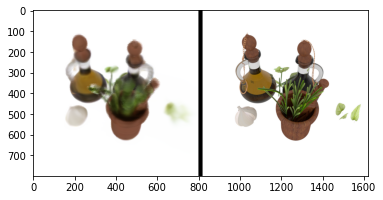

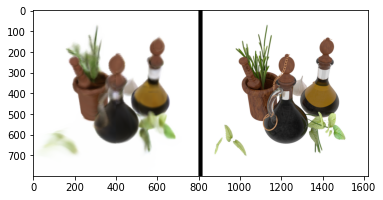

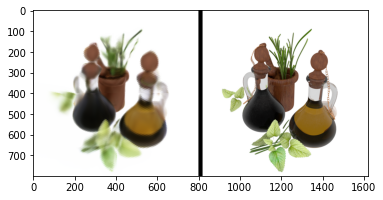

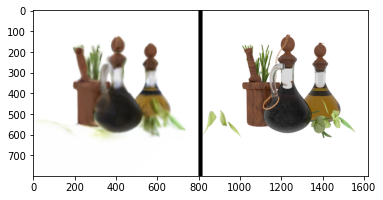

In [116]:
# testfiles = [y[200], y[216], y[255], y[293], y[360]]
testfiles = [y[120], y[140], y[150], y[195]]
print(testfiles)
for i in range(len(testfiles)):
  testfiles[i] = testfiles[i].split('.')[0]
for idx,file in enumerate(testfiles):
  img, _ = generate_rendered_image(file)
  img = img.detach().cpu()
  testimg = Image.open(images + file + '.png')
  testimg = testimg.resize((800,800))
  testimg = np.array(testimg)[:,:,:3]/255
  testimg = torch.from_numpy(testimg)
  image = torch.cat((img, torch.zeros((800,20,3)),testimg), dim = 1)
  plt.imshow(image.numpy())
  plt.savefig(save_image_dir + file + '.png', bbox_inches = 'tight', padding = None)
  plt.show()

## Draw depth map of few scenes

['1_val_0020.txt', '1_val_0040.txt', '1_val_0050.txt', '1_val_0095.txt']


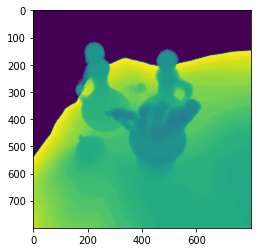

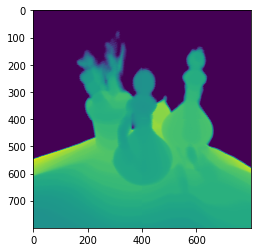

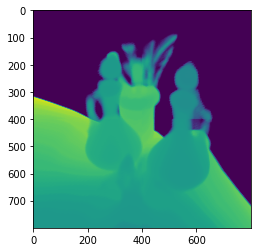

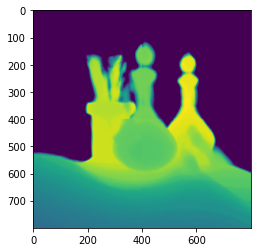

In [118]:
testfiles = [y[120], y[140], y[150], y[195]]
print(testfiles)
for i in range(len(testfiles)):
  testfiles[i] = testfiles[i].split('.')[0]
for idx,file in enumerate(testfiles):
  _, img = generate_rendered_image(file)
  img = img.detach().cpu()
  plt.imshow(img.numpy())
  plt.savefig(save_image_dir + 'depth_map' + file + '.png', bbox_inches = 'tight', padding = None)
  plt.show()